In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications, optimizers, losses
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Flatten, Dense, Dropout, UpSampling2D, GlobalAveragePooling2D, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

### Download the CIFAR10 dataset

The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
(images_train, labels_train), (images_test, labels_test) = datasets.cifar10.load_data()

x_train, x_test = images_train / 255.0, images_test / 255.0

y_train = tf.one_hot(labels_train, 10)[:, 0, :]
y_test = tf.one_hot(labels_test, 10)[:, 0, :]

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.

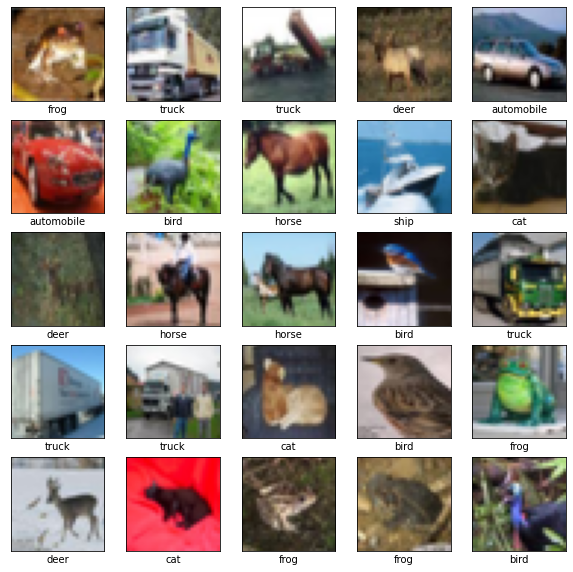

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize = (10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images_train[i], cmap = plt.cm.binary)
  plt.xlabel(class_names[labels_train[i][0]])
plt.show()

### Build Model

In [ ]:
# Built-from-scratch model

model1 = models.Sequential([
    Input(shape = (32, 32, 3)),
    Conv2D(32, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    Conv2D(32, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    MaxPool2D(2, 2),
    Conv2D(64, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    Conv2D(64, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    MaxPool2D(2, 2),
    Conv2D(128, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    Conv2D(128, (3, 3), padding = "same"), BatchNormalization(), Activation("relu"),
    Flatten(),
    Dense(512), BatchNormalization(), Activation("relu"), Dropout(0.2),
    Dense(128), BatchNormalization(), Activation("relu"), Dropout(0.2),
    Dense(10), BatchNormalization(), Activation("softmax"), Dropout(0.2)
])

model1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model1.summary()

model1_history = model1.fit(x_train, y_train, batch_size = 64, epochs = 50, validation_split = 0.1, workers = 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0

In [ ]:
# Built-from-scratch–model test accuracy

y_test_hat1 = np.argmax(model1.predict(x_test), axis = -1)

model1_test_acc = np.mean(y_test_hat1 == np.transpose(labels_test)) * 100

print(f"The built-from-scratch model test accuracy is {model1_test_acc:.2f}%.\n")

for i in range(0, 10):
  current_class = np.where(np.transpose(labels_test)[0] == i)
  current_class_correct = 0
  current_class_total = 0
  for j in current_class[0]:
    if np.transpose(labels_test)[0][j] == y_test_hat1[j]:
      current_class_correct += 1
      current_class_total += 1
    else:
      current_class_total += 1
  current_class_acc = current_class_correct / current_class_total * 100
  print(f"The built-from-scratch model test accuracy for class {class_names[i]} is {current_class_acc:.2f}%.")

The built-from-scratch model test accuracy is 82.43%.

The built-from-scratch model test accuracy for class airplane is 87.50%.
The built-from-scratch model test accuracy for class automobile is 92.00%.
The built-from-scratch model test accuracy for class bird is 72.20%.
The built-from-scratch model test accuracy for class cat is 68.20%.
The built-from-scratch model test accuracy for class deer is 82.80%.
The built-from-scratch model test accuracy for class dog is 72.70%.
The built-from-scratch model test accuracy for class frog is 87.80%.
The built-from-scratch model test accuracy for class horse is 85.90%.
The built-from-scratch model test accuracy for class ship is 89.20%.
The built-from-scratch model test accuracy for class truck is 86.00%.


In [ ]:
# ResNet model

base_model = applications.ResNet152V2(weights = "imagenet", input_shape = (224, 224, 3), include_top = False)

model2 = models.Sequential([
    Input(shape = (32, 32, 3)),
    UpSampling2D(size = (7, 7)),
    base_model,
    GlobalAveragePooling2D(), BatchNormalization(), Dropout(0.2),
    Dense(256), BatchNormalization(), Activation("relu"), Dropout(0.2),
    Dense(10, activation = "softmax")
])

model2.layers[1].trainable = False

model2.summary()

model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model2_history = model2.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_split = 0.1, workers = 64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_11 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                      

In [ ]:
# ResNet-model test accuracy

y_test_hat2 = np.argmax(model2.predict(x_test), axis = -1)

model2_test_acc = np.mean(y_test_hat2 == np.transpose(labels_test)) * 100

print(f"The ResNet model test accuracy is {model2_test_acc:.2f}%.\n")

for i in range(0, 10):
  current_class = np.where(np.transpose(labels_test)[0] == i)
  current_class_correct = 0
  current_class_total = 0
  for j in current_class[0]:
    if np.transpose(labels_test)[0][j] == y_test_hat2[j]:
      current_class_correct += 1
      current_class_total += 1
    else:
      current_class_total += 1
  current_class_acc = current_class_correct / current_class_total * 100
  print(f"The ResNet model test accuracy for class {class_names[i]} is {current_class_acc:.2f}%.")

The ResNet model test accuracy is 89.20%.

The ResNet model test accuracy for class airplane is 91.30%.
The ResNet model test accuracy for class automobile is 93.20%.
The ResNet model test accuracy for class bird is 84.50%.
The ResNet model test accuracy for class cat is 84.00%.
The ResNet model test accuracy for class deer is 86.60%.
The ResNet model test accuracy for class dog is 83.20%.
The ResNet model test accuracy for class frog is 92.00%.
The ResNet model test accuracy for class horse is 92.30%.
The ResNet model test accuracy for class ship is 92.90%.
The ResNet model test accuracy for class truck is 92.00%.


In [ ]:
# Accuracy plots

plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, 51), model1_history.history["accuracy"], label = "Training accuracy")
plt.plot(np.arange(1, 51), model1_history.history["val_accuracy"], label = "Validation accuracy")
plt.title("Built-from-scratch model accuracies")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, 11), model2_history.history["accuracy"], label = "Training accuracy")
plt.plot(np.arange(1, 11), model2_history.history["val_accuracy"], label = "Validation accuracy")
plt.title("ResNet model accuracies")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

[   5   24   25 ... 9985 9989 9993]


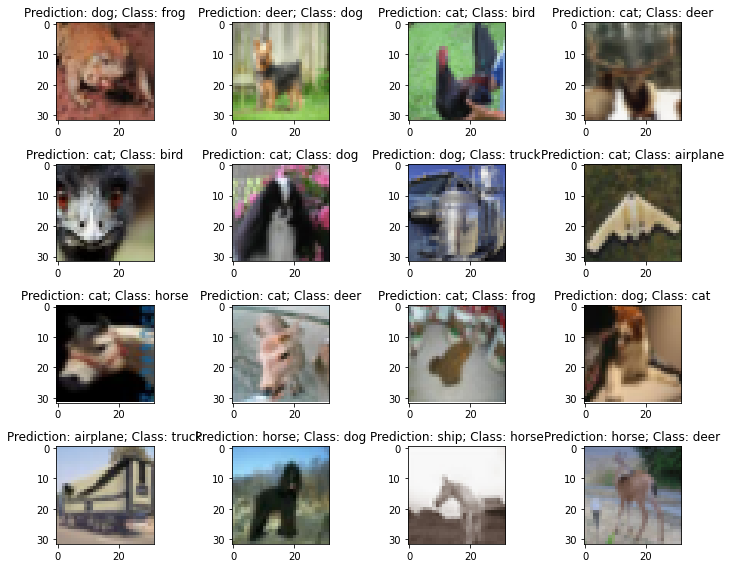

In [ ]:
# Some misclassified images

correct_indices = np.nonzero(y_test_hat1 == np.transpose(labels_test)[0])[0]
incorrect_indices = np.nonzero(y_test_hat1 != np.transpose(labels_test)[0])[0]

plt.figure(figsize = (10, 8))
for i, index in enumerate(incorrect_indices[:16]):
  plt.subplot(4, 4, i + 1)
  plt.imshow(x_test[index], cmap = "gray")
  plt.title(f"Prediction: {class_names[y_test_hat1[index]]}; Class: {class_names[np.transpose(labels_test)[0][index]]}")
plt.tight_layout()